### Extracting features - Finance analysis

### Features Extracted:

- https://github.com/lappis-unb/salic-ml/wiki/Brainstorming-de-features-para-estimar-Complexidade-Financeira
    
Gerar features de um segmento "ESPECÍFICO" e "GLOBAIS".

#### Recarregar automaticamente os módulos

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Importing data

In [38]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


from salicml.utils.dates import Dates
from salicml.utils.read_csv import read_csv
from salicml.utils.utils import debug

PROJECT_ROOT = os.path.abspath(os.path.join(os.pardir, os.pardir))
DATA_FOLDER = os.path.join(PROJECT_ROOT, 'data', 'raw')

#### PLANILHA ORCAMENTARIA

QUERY: /data/scripts/planilha_orcamentaria.sql


In [39]:
dt_comprovacao_name = 'planilha_comprovacao_2.csv'
usecols = ['idPlanilhaAprovacao', 'PRONAC', 'vlComprovacao', 'idSegmento']

dt_items = read_csv(dt_comprovacao_name, usecols=usecols)
display(dt_items.columns)
dt_items.head()

Index(['PRONAC', 'idPlanilhaAprovacao', 'idSegmento', 'vlComprovacao'], dtype='object')

,PRONAC,idPlanilhaAprovacao,idSegmento,vlComprovacao
0,1012121,18552,71,12000.0
1,1012121,18553,71,6000.0
2,1012121,18554,71,12000.0
3,1012121,18555,71,6000.0
4,1012121,18556,71,8000.0


### FEATURES 
    - Valor total comprovado por projeto

# Dividindo pronacs de treino e pronacs de teste

50/50

In [40]:
from sklearn.model_selection import train_test_split


all_pronacs = dt_items.PRONAC.unique()
pronacs_train, pronacs_test = train_test_split(all_pronacs, test_size=0.5)


dt_train = dt_items[dt_items['PRONAC'].isin(pronacs_train)]
dt_test = dt_items[dt_items['PRONAC'].isin(pronacs_test)]

In [41]:
print('pronacs_train = {}'.format(pronacs_train))
print('pronacs_test = {}'.format(pronacs_test))

assert (dt_train.shape[0] + dt_test.shape[0]) == dt_items.shape[0]

display(dt_train.head())
display(dt_test.head())

pronacs_train = [ 175716 1113881  158452 ... 1411071  138997  163773]
pronacs_test = [164031 149753 154096 ... 147888 130343 151352]


,PRONAC,idPlanilhaAprovacao,idSegmento,vlComprovacao
268,1011786,26858,11,50000.0
269,1011786,26858,11,3000.0
270,1011786,26858,11,1000.0
271,1011786,26869,11,2400.0
272,1011786,26870,11,2600.0


,PRONAC,idPlanilhaAprovacao,idSegmento,vlComprovacao
0,1012121,18552,71,12000.0
1,1012121,18553,71,6000.0
2,1012121,18554,71,12000.0
3,1012121,18555,71,6000.0
4,1012121,18556,71,8000.0


In [42]:
segment_projects = dt_train[['PRONAC', 'idSegmento', 'vlComprovacao']].groupby(['idSegmento', 'PRONAC']).sum()
segment_projects.head()

vlComprovacao
idSegmento PRONAC               
11         118216       39956.88
           118687      456234.06
           120629       73446.27
           120729      191029.89
           121761      228091.08

### Plotando as distribuiçoes dos segmentos mais comuns

In [43]:
common_segements = segment_projects.groupby(['idSegmento']).count().sort_values(by='vlComprovacao', ascending=False)
common_segements.rename(columns={'vlComprovacao': 'Número de projetos'}, inplace=True)
display(common_segements.head())

,Número de projetos
idSegmento,
11,309
33,231
12,135
32,119
4B,111


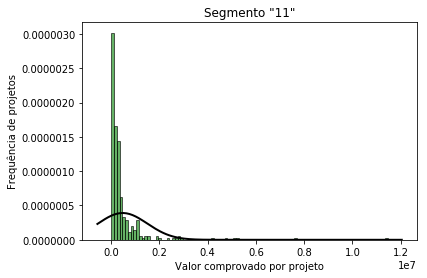

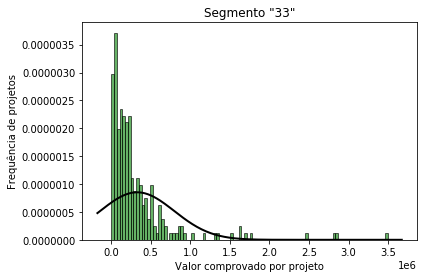

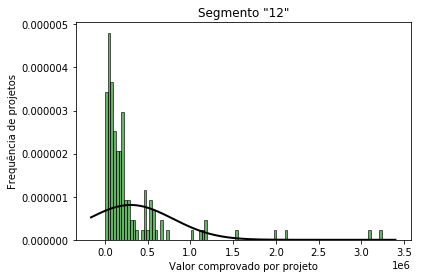

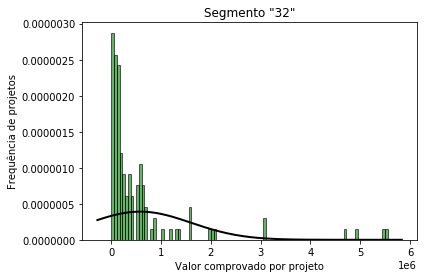

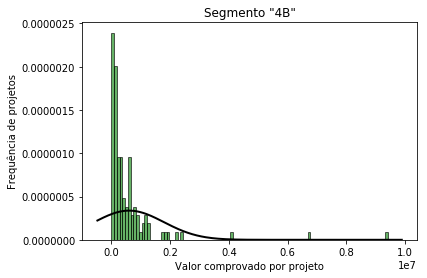

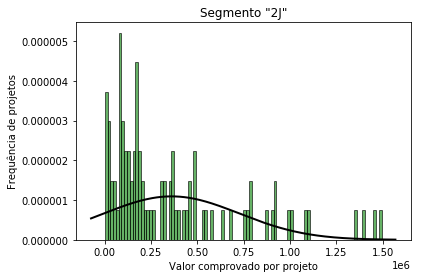

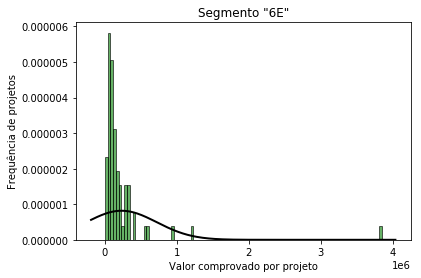

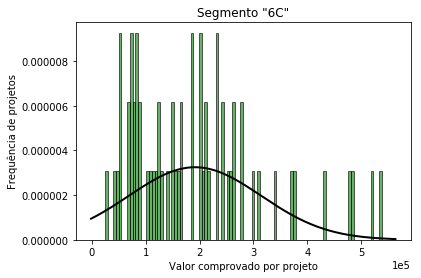

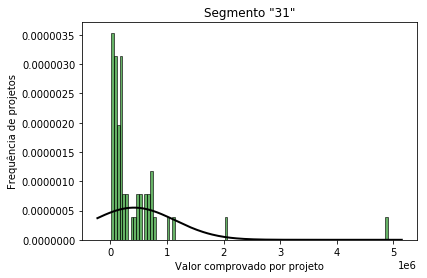

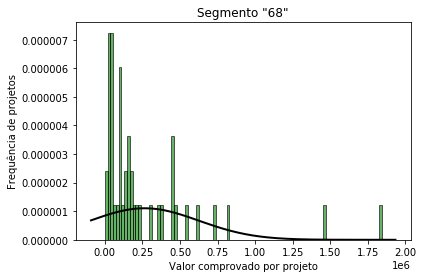

In [48]:
from scipy.stats import norm


def plot_segment(id, funds):
    plt.hist(funds, bins=100, density=True, alpha=0.6, color='g', edgecolor='black')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    plt.title('Segmento "{}"'.format(id))
    plt.xlabel('Valor comprovado por projeto')
    plt.ylabel('Frequência de projetos')

    mu, std = np.mean(funds), np.std(funds)
    
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 200)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    plt.show()

for counter, id_segmento in enumerate(common_segements.index.values):    
    projects_verified_funds = segment_projects.loc[id_segmento].vlComprovacao.values
    plot_segment(id_segmento, projects_verified_funds)
    
    counter += 1
    if counter == 10:
        break

In [53]:
segment_items_avg_std = segment_projects.groupby(['idSegmento'])
segment_items_avg_std = segment_items_avg_std.agg(['count', 'sum', 'mean', 'std'])

segment_items_avg_std.head()

vlComprovacao                                           
                   count           sum           mean           std
idSegmento                                                         
11                   309  1.466028e+08  474442.854466  1.023272e+06
12                   135  4.083835e+07  302506.286148  4.953314e+05
13                    21  4.774144e+06  227340.169524  2.352497e+05
14                     2  1.054016e+06  527008.075000  6.744784e+05
17                    23  4.231627e+06  183983.786087  1.814325e+05

# Calculando a porcentagem de outliers no conjunto de teste

In [55]:
project_items_grp = dt_items.drop(columns=['idPlanilhaAprovacao']).groupby(['PRONAC'])
project_items = project_items_grp.sum()
project_items.head()

,vlComprovacao
PRONAC,
110023,249439.55
110107,47513.83
110131,984250.91
110152,10500.00
110170,491972.94


In [56]:
from salicml.outliers.gaussian_outlier import is_outlier


def is_total_verified_funds_outlier(pronac):
    assert isinstance(pronac, int)
    
    verified_funds = project_items.loc[pronac]['vlComprovacao']
    id_segmento = project_items_grp.get_group(90105).iloc[0]['idSegmento']
    
    mean = segment_items_avg_std.loc[id_segmento]['mean']
    std = segment_items_avg_std.loc[id_segmento]['std']
    outlier = is_outlier(num_items, mean, std)
    return outlier

pronac = np.random.choice(dt_test.PRONAC.values)
is_number_of_items_outlier(90105)

KeyError: 'the label [90105] is not in the [index]'

In [ ]:
from salicml.outliers.gaussian_outlier import outlier_probability


print(1 - outlier_probability(0.0, 1.0, c=1.5))

In [ ]:
pronacs_test = dt_test.PRONAC.unique()

outlier_arr = np.zeros(pronacs_test.size)

for i, pronac in enumerate(pronacs_test):
    outlier = is_number_of_items_outlier(int(pronac))
    outlier_arr[i] = 1.0 if outlier else 0.0
    
describe = pd.DataFrame(outlier_arr).describe()
display(describe)

# Análise dos resultados

Para `c = 1.5`, esperava-se que `6.68%` dos projetos fossem considerados outliers em termos dos números de itens por projeto. Para os conjuntos de treino e teste utilizados e `c = 1.5`, `3.71%`dos projetos foram considerados outliers.